In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import pandas as pd
import konlpy
import re
from collections import Counter

In [2]:
train_data = pd.read_table("./data/ratings_test.txt")
test_data = pd.read_table("./data/ratings_train.txt")

In [3]:
train_data[train_data["document"].isnull()]
test_data[test_data["document"].isnull()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [4]:
train_data = train_data.dropna(axis=0)
sentences = train_data["document"]
label = train_data["label"]

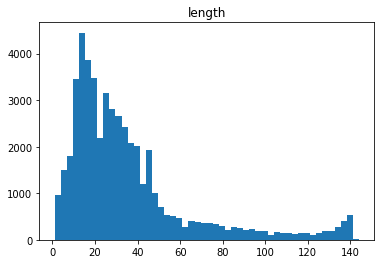

In [5]:
length = [len(sentence) for sentence in sentences]

plt.hist(length, bins=50)
plt.title("length")
plt.show()

In [6]:
#소문자 변경
# ........ 두개로 통일
# !!!!!!! 하나로 통일
#??????? 하나로 통일
# ㅋㅋㅋㅋㅋㅋ 두개로 통일
# """ 하나로 통일
#ㅠㅠㅠㅠㅠㅠ 하나로 통일
#ㅜㅜㅜㅜㅜ하나로 통일
# 이외의 특수문자, 한글 영어 아닌 다른 문자 제거


def preprocess(sentence):
    sentence = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s.,?!\'\"]", "", sentence)
    sentence = re.sub("ㅋ+", "ㅋㅋ", sentence)
    sentence = re.sub("ㅎ+", "ㅎㅎ", sentence)
    sentence = re.sub("ㅜ+", "ㅜ", sentence)
    sentence = re.sub("ㅠ+", "ㅠ", sentence)
    sentence = re.sub("\"+", "\"", sentence)
    sentence = re.sub(r"\.+", "..", sentence)
    sentence = re.sub("!+", "!", sentence)
    sentence = re.sub("\?+", "?", sentence)
    sentence.lower().strip()
    
    return sentence

In [7]:
print(preprocess("뭐야 이 평점들은....%&#####ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ$$$$&*ㅠㅠㅠㅠㅠㅠ??????@!!!!!!"))

뭐야 이 평점들은..?!


In [8]:
corpus = []
labels = []
for i, sentence in enumerate(sentences):
    if len(sentence) < 60:
        corpus.append(preprocess(sentence))
        labels.append(label.iloc[i])
        
y_train = np.array(labels)

In [9]:
vocab_size = 20000
with open("./data/film_review.train.ko.temp", "w") as f:
    for row in corpus:
        f.write(row + "\n")
spm.SentencePieceTrainer.Train(
    "--input={} --model_prefix=korean_spm --vocab_size={}".format("./data/film_review.train.ko.temp", vocab_size)
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=./data/film_review.train.ko.temp --model_prefix=korean_spm --vocab_size=20000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/film_review.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_

In [10]:
s = spm.SentencePieceProcessor()
s.Load("korean_spm.model")

True

In [11]:
def sp_tokenizer(s, corpus):
    tensor = []
    for sentence in corpus:
        tensor.append(s.EncodeAsIds(sentence))
    
    with open("./korean_spm.vocab", "r") as f:
        vocab = f.readlines()
        
    word_index = {}
    index_word = {}
    
    for i, line in enumerate(vocab):
        word = line.split("\t")[0]
        word_index[word] = i
        index_word[i] = word
        
    return tensor, word_index, index_word

In [12]:
tensor, word_index, index_word = sp_tokenizer(s, corpus)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tensor, y_train, test_size = 0.3, random_state=43)

In [14]:
maxlen = 59
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding="pre", 
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        padding="pre", 
                                                        maxlen=maxlen)

Epoch 1/3
59/59 [==============================] - 13s 80ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6929 - val_accuracy: 0.5062
Epoch 2/3
59/59 [==============================] - 3s 50ms/step - loss: 0.6288 - accuracy: 0.6284 - val_loss: 0.5488 - val_accuracy: 0.7195
Epoch 3/3
59/59 [==============================] - 3s 50ms/step - loss: 0.3728 - accuracy: 0.8405 - val_loss: 0.4413 - val_accuracy: 0.8025


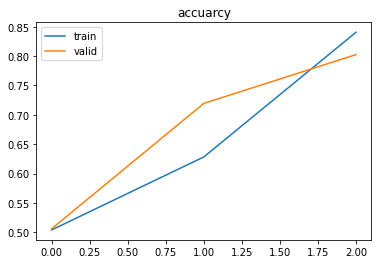

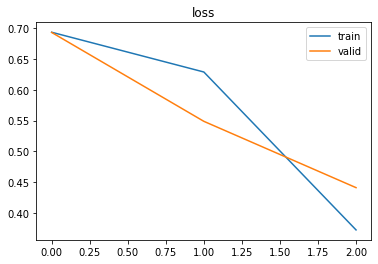

In [15]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, 128))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(64, return_sequences=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(16, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

In [130]:
def konlpy_tokenizer(tokenizer, corpus):
    words = []
    for c in corpus:
        words += tokenizer.morphs(c)
    counter = Counter(words)
    counter = counter.most_common(20000-2)

    words = ["<pad>", "<unk>"] + [key for key, _ in counter]
    word_to_index = {word : index for index, word in enumerate(words)}
    tensor = []

    for c in corpus:
        temp = []
        for s in c.split():
            if s in words:
                temp.append(word_to_index[s])
            else:
                temp.append(word_to_index["<unk>"])
        tensor.append(temp)
    
    return tensor

Epoch 1/3
59/59 [==============================] - 27s 127ms/step - loss: 0.6974 - accuracy: 0.5034 - val_loss: 0.6933 - val_accuracy: 0.5069
Epoch 2/3
59/59 [==============================] - 3s 50ms/step - loss: 0.6920 - accuracy: 0.5152 - val_loss: 0.6879 - val_accuracy: 0.5457
Epoch 3/3
59/59 [==============================] - 3s 50ms/step - loss: 0.6452 - accuracy: 0.6102 - val_loss: 0.6254 - val_accuracy: 0.6269


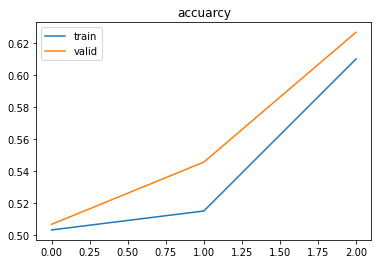

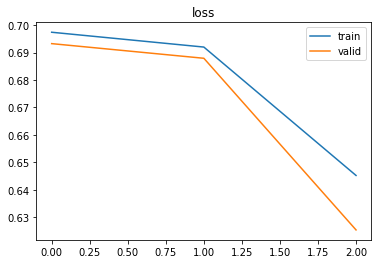

In [131]:
tokenizer = konlpy.tag.Mecab()

tensor = konlpy_tokenizer(tokenizer, corpus)

y_train = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(tensor, y_train, test_size = 0.3, random_state=43)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding="pre", 
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        padding="pre", 
                                                        maxlen=maxlen)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

Epoch 1/3
59/59 [==============================] - 31s 178ms/step - loss: 0.6916 - accuracy: 0.5366 - val_loss: 0.6715 - val_accuracy: 0.5842
Epoch 2/3
59/59 [==============================] - 3s 50ms/step - loss: 0.5845 - accuracy: 0.6832 - val_loss: 0.5831 - val_accuracy: 0.6673
Epoch 3/3
59/59 [==============================] - 3s 51ms/step - loss: 0.4659 - accuracy: 0.7607 - val_loss: 0.5996 - val_accuracy: 0.6844


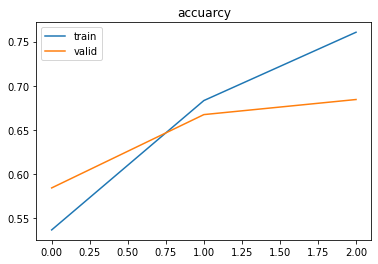

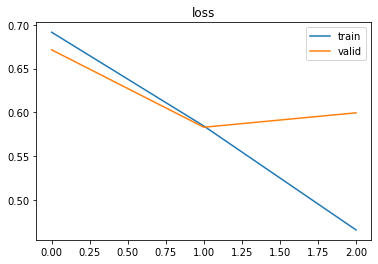

In [133]:
tokenizer = konlpy.tag.Okt()

tensor = konlpy_tokenizer(tokenizer, corpus)

y_train = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(tensor, y_train, test_size = 0.3, random_state=43)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding="pre", 
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        padding="pre", 
                                                        maxlen=maxlen)
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()

In [ ]:
tokenizer = konlpy.tag.Hannanum()

tensor = konlpy_tokenizer(tokenizer, corpus)

y_train = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(tensor, y_train, test_size = 0.3, random_state=43)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        padding="pre", 
                                                        maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, 
                                                        padding="pre", 
                                                        maxlen=maxlen)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test))

accuarcy = history.history["accuracy"]
loss = history.history["loss"]
valid_acc = history.history["val_accuracy"]
valid_loss = history.history["val_loss"]

plt.plot(accuarcy, label="train")
plt.plot(valid_acc, label="valid")
plt.title("accuarcy")
plt.legend()
plt.show()

plt.plot(loss, label="train")
plt.plot(valid_loss, label="valid")
plt.title("loss")
plt.legend()
plt.show()